In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### Read ANIMELIST.CSV

In [2]:
import os
from pathlib import Path

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv",nrows=30000000, low_memory=True,usecols=["user_id","anime_id",'rating'])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
rating_df.shape

(30000000, 3)

## DATA PROCESSING

In [7]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [8]:
rating_df.shape

(19606045, 3)

In [9]:
min_rating = min(rating_df['rating'])

In [10]:
min_rating

0

In [11]:
max_rating = max(rating_df['rating'])

In [12]:
max_rating

10

In [13]:
avg_rating = np.mean(rating_df['rating'])

In [14]:
avg_rating

np.float64(4.045436241730548)

In [15]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [16]:
rating_df.duplicated().sum()

np.int64(1)

In [17]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [18]:
rating_df.drop_duplicates(inplace=True)

In [19]:
user_id = rating_df['user_id'].unique().tolist()

In [20]:
user2user_encode = {x : i for i , x in enumerate(user_id)}

In [21]:
user2user_decoded = {i : x for i , x in enumerate(user_id)}

In [22]:
user2user_decoded[5]

19

In [23]:
user2user_encode[19]

5

In [24]:
rating_df['user'] = rating_df['user_id'].map(user2user_encode)

In [25]:
rating_df.sample()

,user_id,anime_id,rating,user
26380043,85472,23885,0.0,22143


In [26]:
n_user = len(user2user_encode)

In [27]:
n_user

25139

In [28]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encode = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encode)

In [29]:
n_anime = len(anime2anime_encode)

In [30]:
n_anime

17556

In [31]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True) 

In [32]:
rating_df

,user_id,anime_id,rating,user,anime
0,17324,17505,0.0,4408,1939
1,19374,20,0.6,4951,57
2,19083,30240,0.6,4876,1978
3,41085,31483,0.7,10541,6378
4,81777,25429,0.0,21151,1478
...,...,...,...,...,...
19606039,94246,11633,0.6,24388,19
19606040,5912,1470,0.8,1482,23
19606041,7516,16067,0.0,1898,1398
19606042,12682,28171,0.8,3208,67


In [33]:
x = rating_df[['user','anime']].values
y = rating_df['rating']

In [34]:
test_size = 10000
train_indices = rating_df.shape[0] - test_size

In [35]:
train_indices

19596044

In [36]:
X_train , X_test, y_train, y_test = (
    x[:train_indices],
    x[train_indices :],
    y[:train_indices],
    y[train_indices :]
)

In [37]:
X_train.shape

(19596044, 2)

In [38]:
X_test.shape

(10000, 2)

In [39]:
type(X_train)

numpy.ndarray

In [40]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[:, 1]]

In [41]:
type(X_train_array)

list

In [42]:
X_train_array

[array([ 4408,  4951,  4876, ...,  5197, 24743, 17913]),
 array([1939,   57, 1978, ..., 1577,  734,  969])]

In [43]:
X_train

array([[ 4408,  1939],
       [ 4951,    57],
       [ 4876,  1978],
       ...,
       [ 5197,  1577],
       [24743,   734],
       [17913,   969]])

## MODEL ARCHITECTURE

In [44]:
def RecommenderNet():
    embedding_size = 128
    
    user = Input(name='user',shape=[1])
    user_embedding = Embedding(name="user_embedding",input_dim=n_user,output_dim=embedding_size)(user)
    
    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=n_anime, output_dim=embedding_size)(anime)
    
    x = Dot(name="dot_product",normalize=True, axes=2)([user_embedding,anime_embedding])
    
    x = Flatten()(x)
    
    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user,anime],outputs=x)
    model.compile(loss="binary_crossentropy", metrics=['mae','mse'], optimizer="Adam")
    return model
    

In [45]:
model = RecommenderNet()

In [46]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  3,217,792 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,168 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,464,966 (20.85 MB)

 Trainable params: 5,464,964 (20.85 MB)

 Non-trainable params: 2 (8.00 B)

In [47]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs - sustain_epochs) + min_lr

In [48]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss",mode='min',save_best_only=True)
early_stopping = EarlyStopping(patience=5, monitor="val_loss", mode='min', restore_best_weights=True )

In [49]:
my_callbacks = [model_checkpoint,lr_callback, early_stopping]

In [50]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs = 20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks= my_callbacks
)

Epoch 1/20
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 196s 97ms/step - loss: 0.7995 - mae: 0.3841 - mse: 0.1987 - val_loss: 0.7964 - val_mae: 0.3821 - val_mse: 0.1970 - learning_rate: 1.0000e-05
Epoch 2/20
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 191s 97ms/step - loss: 0.7677 - mae: 0.3739 - mse: 0.1864 - val_loss: 0.6246 - val_mae: 0.3006 - val_mse: 0.1244 - learning_rate: 1.0800e-04
Epoch 3/20
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 192s 97ms/step - loss: 0.5803 - mae: 0.2778 - mse: 0.1057 - val_loss: 0.5459 - val_mae: 0.2499 - val_mse: 0.0912 - learning_rate: 2.0600e-04
Epoch 4/20
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 186s 94ms/step - loss: 0.5210 - mae: 0.2334 - mse: 0.0821 - val_loss: 0.5093 - val_mae: 0.2160 - val_mse: 0.0782 - learning_rate: 3.0400e-04
Epoch 5/20
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 178s 90ms/step - loss: 0.4818 - mae: 0.1977 - mse: 0.0682 - val_loss: 0.4956 - val_mae: 0.2000 - val_mse: 0.0738 - learning_rate: 4.0200e-04
Epoch 6/20
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 178s 90ms/step - loss: 0.4596 - mae: 0.1778

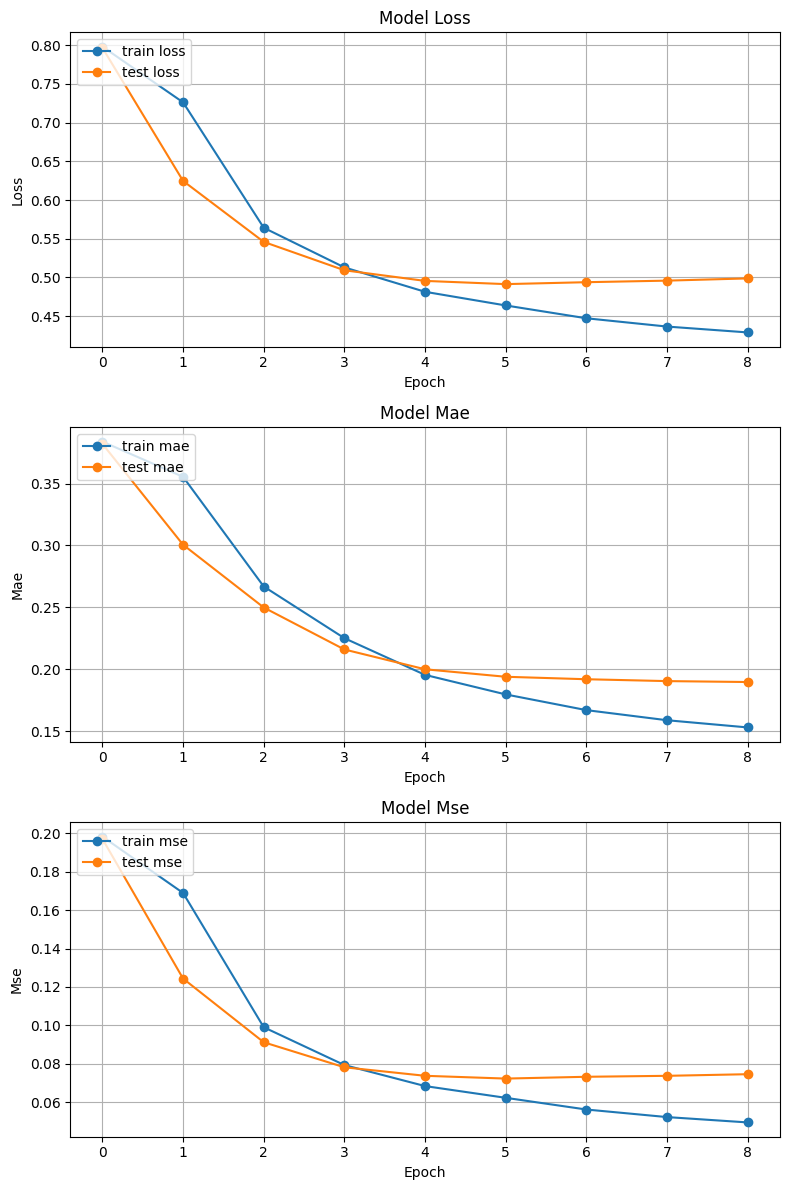

In [51]:
metrics = ['loss', 'mae','mse']

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)
    
plt.tight_layout()
plt.show()

In [52]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [53]:
anime_weights = extract_weights("anime_embedding",model)


In [54]:
user_weights = extract_weights("user_embedding",model)

## READING ANIME.CSV

In [55]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)

In [56]:
df.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0


In [57]:
df.shape

(17562, 35)

In [58]:
df = df.replace("Unknown", np.nan)

In [59]:
df.isna().sum().sort_values(ascending=False)

Licensors        13616
Premiered        12817
English name     10565
Producers         7794
Studios           7079
Score             5141
Source            3567
Score-9           3167
Ranked            1762
Score-2           1597
Score-8           1371
Score-3           1307
Score-4            977
Rating             688
Score-5            584
Duration           555
Episodes           516
Score-6            511
Score-7            503
Score-1            459
Score-10           437
Aired              309
Genres              63
Japanese name       48
Type                37
Name                 0
MAL_ID               0
Members              0
Popularity           0
Dropped              0
Plan to Watch        0
Watching             0
Favorites            0
Completed            0
On-Hold              0
dtype: int64

In [60]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [61]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except Exception as e:
        raise(e)
    return name

In [62]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

In [63]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [64]:
getAnimeName(6702)

'Fairy Tail'

In [65]:
df.sort_values(
    by=['Score'],
    inplace=True,
    ascending=False,
    kind="quicksort",
    na_position="last"
)

In [66]:
df.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate


In [67]:
df = df[['anime_id',"eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [68]:
df

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121
...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",NaN,TV,Summer 2021,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386


In [69]:
def getAnimeFrame(anime,df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [70]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


ANIME_WITH_SYNOPSIS.CSV

In [71]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [72]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [73]:
synopsis_df.head(5)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [74]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

## Content Base recomandation system

In [75]:
pd.set_option("max_colwidth",None)

In [76]:
def find_similar_animes(name,anime_weights,
                        anime2anime_encode,
                        anime2anime_decoded,df,
                        synopsis_df, n=10,
                        retrun_dist=False, neg=False):
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encode.get(index)
        
        weights = anime_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n+1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        print(f"Anime closest to {name}")
        
        if retrun_dist:
            return dists, closest

        SimilarityArr = []
        
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            
            synopsis = getSynopsis(decoded_id,synopsis_df)
            anime_frame = getAnimeFrame(decoded_id,df)
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            
            SimilarityArr.append({
                "anime_id":decoded_id,
                "name": anime_name,
                "similarity":similarity,
                "genre":genre,
                "synopsis": synopsis
            })
            
        Frame = pd.DataFrame(SimilarityArr).sort_values(by='similarity', ascending=False)
         
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
        
    except Exception as e:
        raise e
    

In [77]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encode,
    anime2anime_decoded,
    df,
    synopsis_df
)

Anime closest to Steins;Gate


,name,similarity,genre,synopsis
9,Code Geass:Lelouch of the Rebellion R2,0.718330,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
8,Steins;Gate:The Movie − Load Region of Déjà Vu,0.696743,"Sci-Fi, Drama","fter a year in America, Kurisu Makise returns to Akihabara and reunites with Rintarou Okabe. However, their reunion is cut short when Okabe begins to experience recurring flashes of other timelines as the consequences of his time traveling start to manifest. These side effects eventually culminate in Okabe suddenly vanishing from the world, and only the startled Kurisu has any memory of his existence. In the midst of despair, Kurisu is faced with a truly arduous choice that will test both her duty as a scientist and her loyalty as a friend: follow Okabe's advice and stay away from traveling through time to avoid the potential consequences it may have on the world lines, or ignore it to rescue the person that she cherishes most. Regardless of her decision, the path she chooses is one that will affect the past, the present, and the future."
7,Code Geass:Lelouch of the Rebellion,0.689113,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
6,Fullmetal Alchemist:Brotherhood,0.684654,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide 

In [78]:
getSynopsis(anime="Steins;Gate",synopsis_df=synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

## USER BASED RECOMMENDATION

In [79]:
def find_similar_user(item_input, user_weights, user2user_encode,
                      user2user_decoded,n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encode.get(index)
        
        weights = user_weights
        
        dists = np.dot(weights,weights[encoded_index])
        sorted_dist = np.argsort(dists)
        
        n = n+ 1
        if neg:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]
        if return_dist :
            return dists, closest
        
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]
            
            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similiar_users":decoded_id,
                    "similarity": similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by='similarity', ascending=False)
        similar_users = similar_users[similar_users.similiar_users != item_input]
        return similar_users 
        
    except Exception as e:
        raise e

In [80]:
find_similar_user(int(11880), user_weights, user2user_encode, user2user_decoded) # 68 600

,similiar_users,similarity
9,93870,0.477289
8,85999,0.476907
7,13744,0.466785
6,34374,0.465649
5,7055,0.458862
4,52812,0.457168
3,67787,0.456107
2,33091,0.454063
1,57807,0.451337
0,75928,0.450063


In [81]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color="white",colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [82]:
from collections import defaultdict

In [83]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres= defaultdict(int)
    
    genres_list = []
    for genres in frame['Genres']:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] +=1
    if plot:
        showWordCloud(all_genres)
        
    return genres_list
    

In [84]:
x = getAnimeFrame(1,df)

In [85]:
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


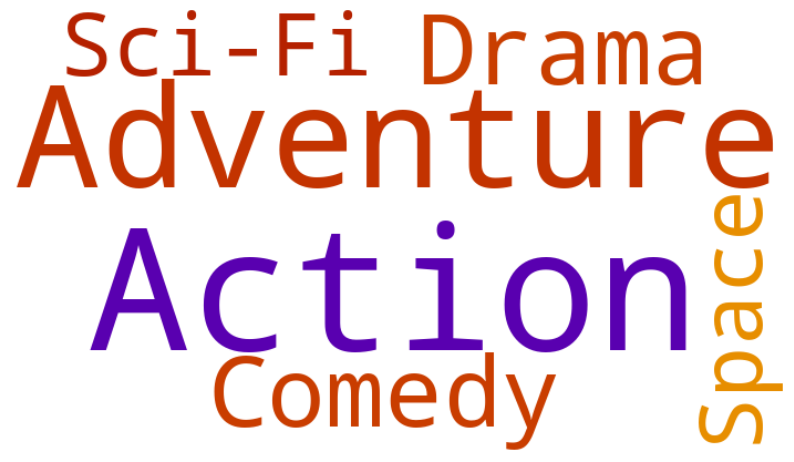

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [86]:
getFavGenre(x, plot=True)

In [142]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    
    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75 )
    
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )
    
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]
    
    if plot:
        getFavGenre(anime_df_rows, plot=plot)
    
    return anime_df_rows
        
    

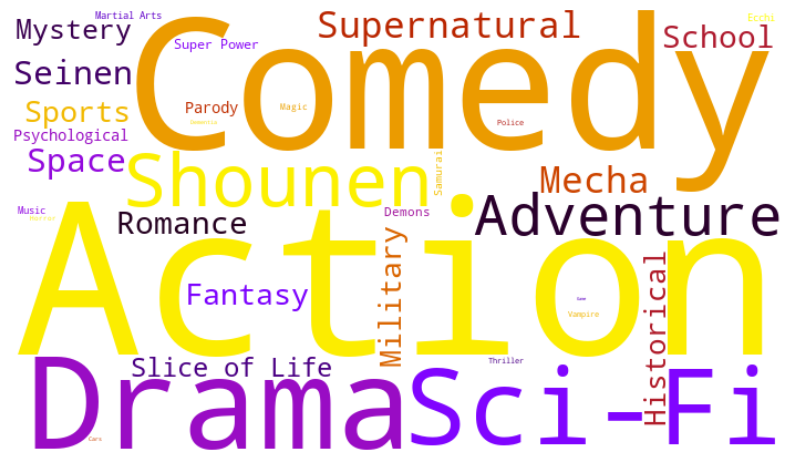

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [143]:
get_user_preferences(11880,rating_df, df,plot=True)

In [144]:
similar_users = find_similar_user(int(11880), user_weights, user2user_encode, user2user_decoded) # 68 600

In [145]:
def get_user_recommedations(similar_users, user_pref,df,
                            synopsis_df, rating_df, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similiar_users.values:
        pref_list = get_user_preferences(user_id, rating_df, df,plot=False)
        
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]
        
        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
    if anime_list:
            anime_list = pd.DataFrame(anime_list)
            
            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
            
            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
                
                if isinstance(anime_name, str):
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)
                    
                    recommended_animes.append({
                        "n": n_user_pref,
                        "anime_name":anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
                
    

In [146]:
user_pref = get_user_preferences(11880,rating_df,df, plot=False)

In [147]:
get_user_recommedations(similar_users,user_pref,df,synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,9,Angel Beats!,"Action, Comedy, Drama, School, Supernatural","Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unravels the mysteries of the afterlife."


## HYBRID RECOMMENDER SYSTEM

In [151]:
def hybrid_recomndation(user_id, user_weight=0.5, content_weight=0.5):
    try:
        ## User Recommendation
        similar_users= find_similar_user(user_id, user_weights, user2user_encode, user2user_decoded)
        user_pref = get_user_preferences(user_id, rating_df, df)
        user_recommended_animes = get_user_recommedations(similar_users,user_pref,df,synopsis_df, rating_df)
        
        user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
        
        #### Content Recommendation 
        content_recommended_animes = []
        
        for anime in user_recommended_anime_list:
            similar_animes = find_similar_animes(anime,anime_weights,anime2anime_encode,anime2anime_decoded,df,synopsis_df)
            
            if similar_animes is not None and not similar_animes.empty:
                content_recommended_animes.extend(similar_animes['name'].tolist())
            else:
                print(f"No similar anime found{anime}")
                
        combined_scores = {}
        
        for anime in user_recommended_anime_list:
            combined_scores[anime]   = combined_scores.get(anime, 0) + user_weight
            
        for anime in content_recommended_animes:
            combined_scores[anime] = combined_scores.get(anime,0) + content_weight
             
        sorted_animes = sorted(combined_scores.items(), key=lambda x:x[1], reverse=True)
        
        return [anime for anime, score in sorted_animes[:10]]
    except Exception as e:
         print(e)

In [153]:
hybrid_recomndation(15597)

Anime closest to Bakuman.
Anime closest to Okami-San and Her Seven Companions
Anime closest to Kämpfer
Anime closest to Shaman King
Anime closest to Mobile Suit Gundam Wing:Endless Waltz
Anime closest to Nura:Rise of the Yokai Clan
Anime closest to Naruto
Anime closest to Soul Eater
Anime closest to Rosario + Vampire
Anime closest to Trinity Blood


['Bakuman.',
 'Ladies versus Butlers!',
 'Kämpfer',
 'Mobile Suit Gundam Wing:Endless Waltz',
 'Rosario + Vampire',
 'MM!',
 'Demon King Daimao',
 'Princess Lover!',
 'Omamori Himari',
 'Rosario + Vampire Capu2']